In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Simple sequence data: predict next value
X_sequences = torch.tensor([
    [[0.1], [0.2], [0.3]],  # Sequence 1
    [[0.2], [0.3], [0.4]],  # Sequence 2
    [[0.3], [0.4], [0.5]],  # Sequence 3
    [[0.4], [0.5], [0.6]],  # Sequence 4
], dtype=torch.float32)

y_targets = torch.tensor([
    [0.4],  # Target for sequence 1
    [0.5],  # Target for sequence 2
    [0.6],  # Target for sequence 3
    [0.7],  # Target for sequence 4
], dtype=torch.float32)

print("Training Data:")
for i in range(len(X_sequences)):
    seq = [x.item() for x in X_sequences[i]]
    target = y_targets[i].item()
    print(f"  Sequence {i+1}: {seq} → {target}")

Training Data:
  Sequence 1: [0.10000000149011612, 0.20000000298023224, 0.30000001192092896] → 0.4000000059604645
  Sequence 2: [0.20000000298023224, 0.30000001192092896, 0.4000000059604645] → 0.5
  Sequence 3: [0.30000001192092896, 0.4000000059604645, 0.5] → 0.6000000238418579
  Sequence 4: [0.4000000059604645, 0.5, 0.6000000238418579] → 0.699999988079071


In [3]:
# LSTM Parameters
input_size = 1
hidden_size = 4
output_size = 1

print(f"Input size: {input_size}")
print(f"Hidden size: {hidden_size}")
print(f"Output size: {output_size}")

Input size: 1
Hidden size: 4
Output size: 1


In [4]:
def sigmoid(x):
    """Sigmoid activation: σ(x) = 1 / (1 + e^(-x))"""
    return 1 / (1 + torch.exp(-x))

def sigmoid_derivative(x):
    """Derivative of sigmoid: σ'(x) = σ(x) * (1 - σ(x))"""
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    """Tanh activation"""
    return torch.tanh(x)

def tanh_derivative(x):
    """Derivative of tanh: 1 - tanh(x)^2"""
    return 1 - torch.tanh(x) ** 2

print("Activation functions defined!")

Activation functions defined!


In [5]:
def init_lstm_weights(input_size, hidden_size, output_size):
    """
    Initialize LSTM weights.
    Each gate has weights for [x_t, h_{t-1}] concatenation.
    """
    concat_size = input_size + hidden_size
    
    # Forget gate weights
    W_f = torch.randn(concat_size, hidden_size) * 0.1
    b_f = torch.zeros(1, hidden_size)
    
    # Input gate weights
    W_i = torch.randn(concat_size, hidden_size) * 0.1
    b_i = torch.zeros(1, hidden_size)
    
    # Candidate (cell) gate weights
    W_c = torch.randn(concat_size, hidden_size) * 0.1
    b_c = torch.zeros(1, hidden_size)
    
    # Output gate weights
    W_o = torch.randn(concat_size, hidden_size) * 0.1
    b_o = torch.zeros(1, hidden_size)
    
    # Output layer weights (hidden to output)
    W_y = torch.randn(hidden_size, output_size) * 0.1
    b_y = torch.zeros(1, output_size)
    
    weights = {
        'W_f': W_f, 'b_f': b_f,
        'W_i': W_i, 'b_i': b_i,
        'W_c': W_c, 'b_c': b_c,
        'W_o': W_o, 'b_o': b_o,
        'W_y': W_y, 'b_y': b_y
    }
    
    return weights

# Initialize
weights = init_lstm_weights(input_size, hidden_size, output_size)

print("LSTM Weights initialized:")
print(f"  Forget gate W_f: {weights['W_f'].shape}")
print(f"  Input gate W_i: {weights['W_i'].shape}")
print(f"  Candidate W_c: {weights['W_c'].shape}")
print(f"  Output gate W_o: {weights['W_o'].shape}")
print(f"  Output layer W_y: {weights['W_y'].shape}")

LSTM Weights initialized:
  Forget gate W_f: torch.Size([5, 4])
  Input gate W_i: torch.Size([5, 4])
  Candidate W_c: torch.Size([5, 4])
  Output gate W_o: torch.Size([5, 4])
  Output layer W_y: torch.Size([4, 1])


In [6]:
def lstm_cell_forward(x_t, h_prev, c_prev, weights):
    """
    Single LSTM cell forward pass.
    
    Args:
        x_t: Input at time t (1, input_size)
        h_prev: Previous hidden state (1, hidden_size)
        c_prev: Previous cell state (1, hidden_size)
        weights: Dictionary of weights
    
    Returns:
        h_t: New hidden state
        c_t: New cell state
        cache: Values needed for backprop
    """
    # Concatenate input and previous hidden state
    concat = torch.cat([x_t, h_prev], dim=1)  # (1, input_size + hidden_size)
    
    # Forget Gate: what to forget from cell state
    f_gate_pre = torch.matmul(concat, weights['W_f']) + weights['b_f']
    f_t = sigmoid(f_gate_pre)
    
    # Input Gate: what new info to store
    i_gate_pre = torch.matmul(concat, weights['W_i']) + weights['b_i']
    i_t = sigmoid(i_gate_pre)
    
    # Candidate cell state
    c_gate_pre = torch.matmul(concat, weights['W_c']) + weights['b_c']
    c_tilde = tanh(c_gate_pre)
    
    # Output Gate: what to output
    o_gate_pre = torch.matmul(concat, weights['W_o']) + weights['b_o']
    o_t = sigmoid(o_gate_pre)
    
    # Update cell state: c_t = f_t * c_prev + i_t * c_tilde
    c_t = f_t * c_prev + i_t * c_tilde
    
    # Update hidden state: h_t = o_t * tanh(c_t)
    h_t = o_t * tanh(c_t)
    
    # Store values for backpropagation
    cache = {
        'x_t': x_t, 'h_prev': h_prev, 'c_prev': c_prev,
        'concat': concat,
        'f_gate_pre': f_gate_pre, 'f_t': f_t,
        'i_gate_pre': i_gate_pre, 'i_t': i_t,
        'c_gate_pre': c_gate_pre, 'c_tilde': c_tilde,
        'o_gate_pre': o_gate_pre, 'o_t': o_t,
        'c_t': c_t, 'h_t': h_t
    }
    
    return h_t, c_t, cache

print("LSTM cell forward function defined!")

LSTM cell forward function defined!


In [7]:
def lstm_forward(X_seq, weights, h_init=None, c_init=None):
    """
    Forward pass through LSTM for entire sequence.
    
    Args:
        X_seq: Input sequence (seq_len, input_size)
        weights: Dictionary of weights
        h_init: Initial hidden state
        c_init: Initial cell state
    
    Returns:
        y_pred: Final output prediction
        caches: List of caches for each time step
    """
    seq_len = X_seq.shape[0]
    
    # Initialize states
    if h_init is None:
        h_init = torch.zeros(1, hidden_size)
    if c_init is None:
        c_init = torch.zeros(1, hidden_size)
    
    h_t = h_init
    c_t = c_init
    caches = []
    
    # Process each time step
    for t in range(seq_len):
        x_t = X_seq[t].unsqueeze(0)  # (1, input_size)
        h_t, c_t, cache = lstm_cell_forward(x_t, h_t, c_t, weights)
        caches.append(cache)
    
    # Output layer (using final hidden state)
    y_pred = torch.matmul(h_t, weights['W_y']) + weights['b_y']
    
    return y_pred, h_t, c_t, caches

# Test forward pass
y_pred, h_final, c_final, caches = lstm_forward(X_sequences[0], weights)
print(f"Input sequence: {[x.item() for x in X_sequences[0]]}")
print(f"Predicted output: {y_pred.item():.4f}")
print(f"Target: {y_targets[0].item()}")

Input sequence: [0.10000000149011612, 0.20000000298023224, 0.30000001192092896]
Predicted output: 0.0001
Target: 0.4000000059604645


In [8]:
def lstm_forward_verbose(X_seq, weights):
    """Forward pass with detailed output."""
    
    print("="*70)
    print("LSTM FORWARD PASS (Step by Step)")
    print("="*70)
    
    seq_len = X_seq.shape[0]
    h_t = torch.zeros(1, hidden_size)
    c_t = torch.zeros(1, hidden_size)
    
    print(f"\nInitial hidden state h_0: {h_t.flatten()[:2].tolist()}...")
    print(f"Initial cell state c_0: {c_t.flatten()[:2].tolist()}...")
    
    for t in range(seq_len):
        print(f"\n{'─'*70}")
        print(f"TIME STEP t = {t+1}")
        print(f"{'─'*70}")
        
        x_t = X_seq[t].unsqueeze(0)
        print(f"Input x_{t+1} = {x_t.flatten().tolist()}")
        
        # Concatenate
        concat = torch.cat([x_t, h_t], dim=1)
        print(f"Concat [x_t, h_t]: shape {concat.shape}")
        
        # Gates
        f_t = sigmoid(torch.matmul(concat, weights['W_f']) + weights['b_f'])
        i_t = sigmoid(torch.matmul(concat, weights['W_i']) + weights['b_i'])
        c_tilde = tanh(torch.matmul(concat, weights['W_c']) + weights['b_c'])
        o_t = sigmoid(torch.matmul(concat, weights['W_o']) + weights['b_o'])
        
        print(f"\n1. Forget Gate f_t = σ(W_f·[x,h] + b_f)")
        print(f"   f_t = {f_t.flatten()[:2].tolist()}... (what to forget)")
        
        print(f"\n2. Input Gate i_t = σ(W_i·[x,h] + b_i)")
        print(f"   i_t = {i_t.flatten()[:2].tolist()}... (what to update)")
        
        print(f"\n3. Candidate c̃_t = tanh(W_c·[x,h] + b_c)")
        print(f"   c̃_t = {c_tilde.flatten()[:2].tolist()}... (new candidate values)")
        
        print(f"\n4. Output Gate o_t = σ(W_o·[x,h] + b_o)")
        print(f"   o_t = {o_t.flatten()[:2].tolist()}... (what to output)")
        
        # Update states
        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * tanh(c_t)
        
        print(f"\n5. Cell State: c_t = f_t ⊙ c_{{t-1}} + i_t ⊙ c̃_t")
        print(f"   c_t = {c_t.flatten()[:2].tolist()}...")
        
        print(f"\n6. Hidden State: h_t = o_t ⊙ tanh(c_t)")
        print(f"   h_t = {h_t.flatten()[:2].tolist()}...")
    
    # Output
    y_pred = torch.matmul(h_t, weights['W_y']) + weights['b_y']
    print(f"\n{'='*70}")
    print(f"OUTPUT LAYER: y = h_T · W_y + b_y = {y_pred.item():.4f}")
    print(f"{'='*70}")
    
    return y_pred

# Run verbose forward pass
_ = lstm_forward_verbose(X_sequences[0], weights)

LSTM FORWARD PASS (Step by Step)

Initial hidden state h_0: [0.0, 0.0]...
Initial cell state c_0: [0.0, 0.0]...

──────────────────────────────────────────────────────────────────────
TIME STEP t = 1
──────────────────────────────────────────────────────────────────────
Input x_1 = [0.10000000149011612]
Concat [x_t, h_t]: shape torch.Size([1, 5])

1. Forget Gate f_t = σ(W_f·[x,h] + b_f)
   f_t = [0.5048171281814575, 0.5037181377410889]... (what to forget)

2. Input Gate i_t = σ(W_i·[x,h] + b_i)
   i_t = [0.5007972121238708, 0.4989386796951294]... (what to update)

3. Candidate c̃_t = tanh(W_c·[x,h] + b_c)
   c̃_t = [0.0014533756766468287, 0.0023105095606297255]... (new candidate values)

4. Output Gate o_t = σ(W_o·[x,h] + b_o)
   o_t = [0.4992087483406067, 0.5014715790748596]... (what to output)

5. Cell State: c_t = f_t ⊙ c_{t-1} + i_t ⊙ c̃_t
   c_t = [0.0007278464618138969, 0.0011528026079759002]...

6. Hidden State: h_t = o_t ⊙ tanh(c_t)
   h_t = [0.0003633472661022097, 0.0005780975

In [9]:
def mse_loss(y_true, y_pred):
    """Mean Squared Error loss"""
    return torch.mean((y_true - y_pred) ** 2)

print("MSE Loss function defined!")

MSE Loss function defined!


In [10]:
def lstm_backward(y_true, y_pred, caches, weights):
    """
    Backpropagation Through Time for LSTM.
    
    Returns gradients for all weights.
    """
    # Initialize gradients
    grads = {key: torch.zeros_like(val) for key, val in weights.items()}
    
    # Output layer gradient
    dy = 2 * (y_pred - y_true)  # dL/dy for MSE
    
    # Gradients for output layer
    h_final = caches[-1]['h_t']
    grads['W_y'] = torch.matmul(h_final.T, dy)
    grads['b_y'] = dy.clone()
    
    # Gradient flowing to final hidden state
    dh_next = torch.matmul(dy, weights['W_y'].T)
    dc_next = torch.zeros(1, hidden_size)
    
    # Backpropagate through time
    for t in reversed(range(len(caches))):
        cache = caches[t]
        
        # Retrieve cached values
        concat = cache['concat']
        f_t = cache['f_t']
        i_t = cache['i_t']
        c_tilde = cache['c_tilde']
        o_t = cache['o_t']
        c_t = cache['c_t']
        c_prev = cache['c_prev']
        f_gate_pre = cache['f_gate_pre']
        i_gate_pre = cache['i_gate_pre']
        c_gate_pre = cache['c_gate_pre']
        o_gate_pre = cache['o_gate_pre']
        
        # Gradient of hidden state
        # h_t = o_t * tanh(c_t)
        do = dh_next * tanh(c_t)
        dc = dh_next * o_t * tanh_derivative(c_t) + dc_next
        
        # Gradient of cell state update
        # c_t = f_t * c_prev + i_t * c_tilde
        df = dc * c_prev
        dc_prev = dc * f_t
        di = dc * c_tilde
        dc_tilde = dc * i_t
        
        # Gradient through activations
        df_pre = df * sigmoid_derivative(f_gate_pre)
        di_pre = di * sigmoid_derivative(i_gate_pre)
        dc_tilde_pre = dc_tilde * tanh_derivative(c_gate_pre)
        do_pre = do * sigmoid_derivative(o_gate_pre)
        
        # Accumulate weight gradients
        grads['W_f'] += torch.matmul(concat.T, df_pre)
        grads['b_f'] += df_pre
        grads['W_i'] += torch.matmul(concat.T, di_pre)
        grads['b_i'] += di_pre
        grads['W_c'] += torch.matmul(concat.T, dc_tilde_pre)
        grads['b_c'] += dc_tilde_pre
        grads['W_o'] += torch.matmul(concat.T, do_pre)
        grads['b_o'] += do_pre
        
        # Gradient to previous hidden state
        d_concat = (torch.matmul(df_pre, weights['W_f'].T) +
                   torch.matmul(di_pre, weights['W_i'].T) +
                   torch.matmul(dc_tilde_pre, weights['W_c'].T) +
                   torch.matmul(do_pre, weights['W_o'].T))
        
        dh_next = d_concat[:, input_size:]  # Hidden state part
        dc_next = dc_prev
    
    return grads

print("LSTM backward function defined!")

LSTM backward function defined!


In [11]:
# Hyperparameters
learning_rate = 0.5
epochs = 500

# Re-initialize weights
torch.manual_seed(42)
weights = init_lstm_weights(input_size, hidden_size, output_size)

# Store losses
losses = []

print("Training LSTM...")
print("="*50)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    # Accumulate gradients
    total_grads = {key: torch.zeros_like(val) for key, val in weights.items()}
    
    for i in range(len(X_sequences)):
        # Forward pass
        y_pred, _, _, caches = lstm_forward(X_sequences[i], weights)
        
        # Compute loss
        loss = mse_loss(y_targets[i:i+1], y_pred)
        epoch_loss += loss.item()
        
        # Backward pass
        grads = lstm_backward(y_targets[i:i+1], y_pred, caches, weights)
        
        # Accumulate gradients
        for key in total_grads:
            total_grads[key] += grads[key]
    
    # Average gradients
    n_samples = len(X_sequences)
    for key in total_grads:
        total_grads[key] /= n_samples
    
    # Gradient clipping
    clip_value = 5.0
    for key in total_grads:
        total_grads[key] = torch.clamp(total_grads[key], -clip_value, clip_value)
    
    # Update weights
    for key in weights:
        weights[key] = weights[key] - learning_rate * total_grads[key]
    
    # Store average loss
    avg_loss = epoch_loss / n_samples
    losses.append(avg_loss)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d} | Loss: {avg_loss:.6f}")

print(f"\nFinal Loss: {losses[-1]:.6f}")

Training LSTM...
Epoch    0 | Loss: 0.314855
Epoch   50 | Loss: 0.012478
Epoch  100 | Loss: 0.012459
Epoch  150 | Loss: 0.012427
Epoch  200 | Loss: 0.012371
Epoch  250 | Loss: 0.012273
Epoch  300 | Loss: 0.012100
Epoch  350 | Loss: 0.011800
Epoch  400 | Loss: 0.011289
Epoch  450 | Loss: 0.010437

Final Loss: 0.009102


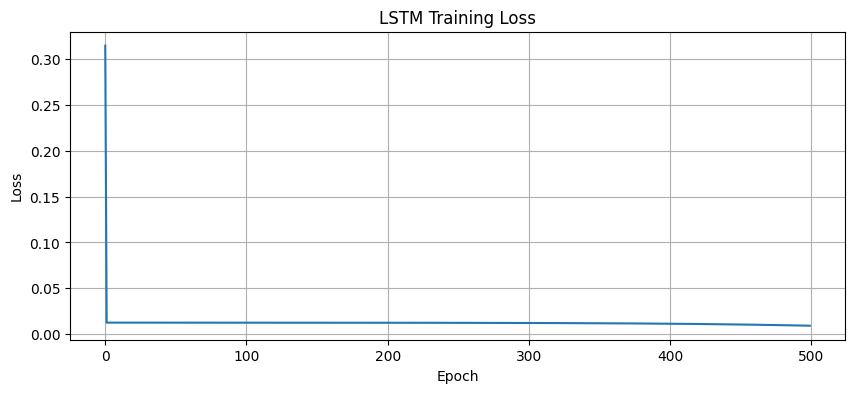

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss')
plt.grid(True)
plt.show()

In [13]:
print("Predictions on Training Data:")
print("="*60)
print(f"{'Sequence':<25} {'Target':<10} {'Predicted':<10} {'Error':<10}")
print("-"*60)

for i in range(len(X_sequences)):
    y_pred, _, _, _ = lstm_forward(X_sequences[i], weights)
    seq = [x.item() for x in X_sequences[i]]
    target = y_targets[i].item()
    pred = y_pred.item()
    error = abs(target - pred)
    print(f"{str(seq):<25} {target:<10.4f} {pred:<10.4f} {error:<10.4f}")

print("\n✓ LSTM has learned to predict the next number in the sequence!")

Predictions on Training Data:
Sequence                  Target     Predicted  Error     
------------------------------------------------------------
[0.10000000149011612, 0.20000000298023224, 0.30000001192092896] 0.4000     0.5281     0.1281    
[0.20000000298023224, 0.30000001192092896, 0.4000000059604645] 0.5000     0.5430     0.0430    
[0.30000001192092896, 0.4000000059604645, 0.5] 0.6000     0.5579     0.0421    
[0.4000000059604645, 0.5, 0.6000000238418579] 0.7000     0.5726     0.1274    

✓ LSTM has learned to predict the next number in the sequence!


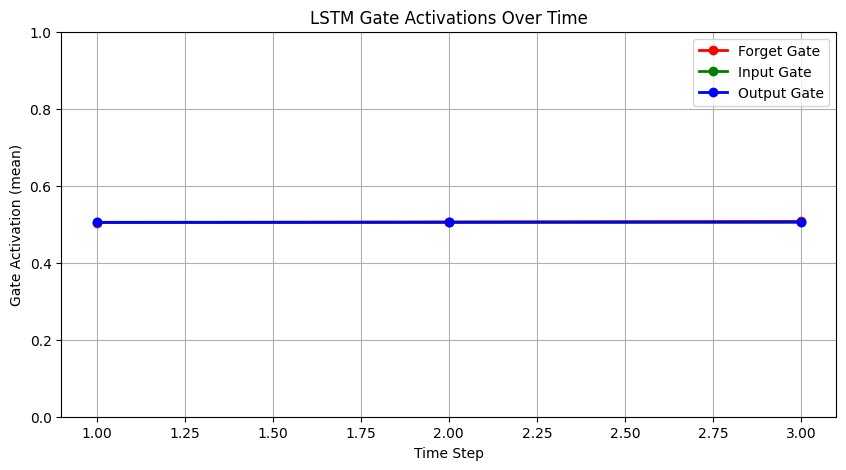

In [14]:
# Visualize gate activations for one sequence
_, _, _, caches = lstm_forward(X_sequences[0], weights)

# Extract gate values
forget_gates = [c['f_t'].mean().item() for c in caches]
input_gates = [c['i_t'].mean().item() for c in caches]
output_gates = [c['o_t'].mean().item() for c in caches]

time_steps = range(1, len(caches) + 1)

plt.figure(figsize=(10, 5))
plt.plot(time_steps, forget_gates, 'r-o', label='Forget Gate', linewidth=2)
plt.plot(time_steps, input_gates, 'g-o', label='Input Gate', linewidth=2)
plt.plot(time_steps, output_gates, 'b-o', label='Output Gate', linewidth=2)

plt.xlabel('Time Step')
plt.ylabel('Gate Activation (mean)')
plt.title('LSTM Gate Activations Over Time')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

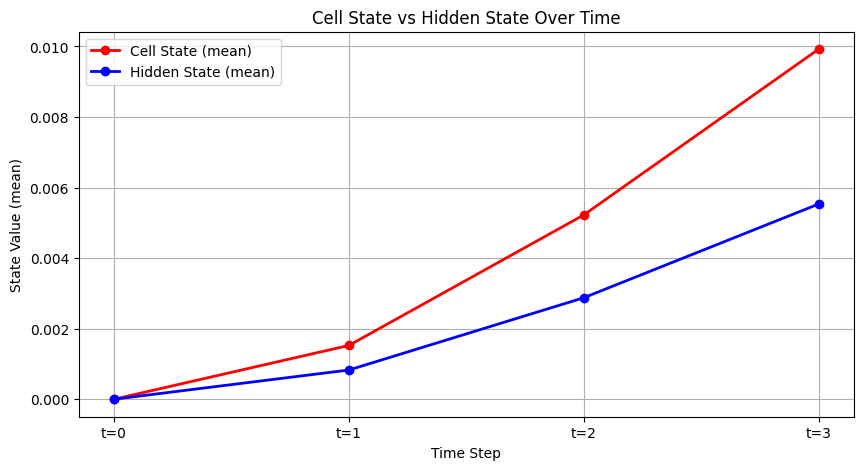

In [15]:
# Visualize cell state vs hidden state evolution
cell_states = [torch.zeros(1, hidden_size)] + [c['c_t'] for c in caches]
hidden_states = [torch.zeros(1, hidden_size)] + [c['h_t'] for c in caches]

cell_means = [c.mean().item() for c in cell_states]
hidden_means = [h.mean().item() for h in hidden_states]

time_steps = range(len(cell_states))

plt.figure(figsize=(10, 5))
plt.plot(time_steps, cell_means, 'r-o', label='Cell State (mean)', linewidth=2)
plt.plot(time_steps, hidden_means, 'b-o', label='Hidden State (mean)', linewidth=2)

plt.xlabel('Time Step')
plt.ylabel('State Value (mean)')
plt.title('Cell State vs Hidden State Over Time')
plt.xticks(time_steps, ['t=0'] + [f't={i+1}' for i in range(len(caches))])
plt.legend()
plt.grid(True)
plt.show()